In [1]:
%matplotlib inline

In [2]:
%reload_ext autoreload
%autoreload 2
import torch
from fastai.vision.all import *

In [3]:
import wandb
api = wandb.Api()

In [4]:
def get_df(runs):
    id_df=pd.DataFrame({'id':[run.id for run in runs]})
    summary_df = pd.DataFrame.from_records([{k:v for k,v in run.summary._json_dict.items() if not k.startswith('_')} for run in runs]) 
    config_df = pd.DataFrame.from_records([{k:v for k,v in run.config.items() if not k.startswith('_')} for run in runs])
    return pd.concat([id_df,config_df,summary_df],axis=1)

In [5]:
import sys
sys.path.append('../')
%env DISENTANGLEMENT_LIB_DATA=/data/disentanglement
from disvae import init_specific_model
def get_representation_fn(run,img_shape=[1,64,64],device='cuda',model_file="model.pt"):
    group=run.config['group']
    dim=run.config['num_latent']
    model_type=run.config['model_type']
    simultaneous = run.config['simultaneous']
    model = init_specific_model(model_type,img_shape,dim,group)
    ans = run.file(model_file).download('tmp',True)
    model.load_state_dict(torch.load(ans.name))
    model.to(device)
    model.eval()
    def representation_fn(obs):
        obs = torch.tensor(obs.transpose([0,3,1,2]),dtype=torch.float32,device=device)
        with torch.no_grad():
            mean,_ = model.encoder(obs)
        return mean.data.cpu().numpy()
    return representation_fn,model

env: DISENTANGLEMENT_LIB_DATA=/data/disentanglement


In [7]:
from disentanglement_lib.visualize import visualize_scores
from disentanglement_lib.visualize import visualize_model
from disentanglement_lib.evaluation.metrics import mig,factor_vae,dci,modularity_explicitness,sap_score,unified_scores
from disentanglement_lib.data.ground_truth.named_data import get_named_ground_truth_data

In [6]:
runs = api.runs("erow/fractionVAE",{"$and":[{"config.dataset":"dsprites_full"},
                                            {"config.seed":574},
                                           {"state":"finished"}]})
our = get_df(runs)
len(runs)

7

In [7]:
our[['beta','discrete_mig','KL_loss','discrete_d_mig']]

,beta,discrete_mig,KL_loss,discrete_d_mig
0,6,0.195789,12.571031,"[0.14401412102810102, 0.401889267061617, 0.16310575466750102, 0.19134258232205248, 0.0785957434635413]"
1,30,0.139097,4.694238,"[0.019025052198382904, 0.07014790199246157, 0.004248787021769469, 0.5903119386386471, 0.011749449939426964]"
2,40,0.125868,4.037014,"[0.02619910689111548, 0.0639166463324267, 0.00015403714012408209, 0.5296622922216587, 0.009409383943275422]"
3,50,0.243057,3.416374,"[0.05110252272512703, 0.14222155371895195, 0.00038842834105299256, 0.4964267807878812, 0.525148000352162]"
4,60,0.245080,2.893575,"[0.04715154881692077, 0.22708383015402536, 0.0006574566662879774, 0.44784528860149625, 0.5026610348964888]"
5,70,0.197022,2.399475,"[0.007017070811306782, 0.05477819897508072, 0.0006251575533607672, 0.4506459660030289, 0.4720454620798978]"
6,80,0.172200,2.129492,"[0.004046009882524332, 0.031883675277978286, 9.972394215474306e-05, 0.4189961890442277, 0.4059743123084179]"


In [1]:
def pure(mi):
    mi = np.array(mi)
    mi /= np.log(np.array([3,6,40,32,32]))
    d_pure = mi.sum(1) - mi.max(1)
    return d_pure

In [9]:
pd.DataFrame(np.array(our['discrete_mi'].apply(pure).tolist())).round(2)

,0,1,2,3,4,5,6,7,8,9
0,0.06,0.28,0.10,0.10,0.05,0.08,0.11,0.09,0.46,0.27
1,0.04,0.17,0.09,0.07,0.12,0.08,0.17,0.26,0.07,0.07
2,0.04,0.16,0.08,0.09,0.08,0.17,0.14,0.26,0.11,0.10
3,0.05,0.19,0.13,0.14,0.19,0.05,0.19,0.24,0.10,0.14
4,0.08,0.20,0.14,0.12,0.18,0.08,0.15,0.17,0.15,0.11
5,0.10,0.18,0.16,0.12,0.14,0.10,0.16,0.20,0.14,0.12
6,0.10,0.11,0.15,0.15,0.17,0.09,0.13,0.13,0.17,0.15


In [10]:
pd.concat([our['discrete_mi'].apply(pure),our['beta']],axis=1)

,discrete_mi,beta
0,"[0.05679306188031996, 0.27518803329767283, 0.10277162684098853, 0.10332861916808644, 0.050905993817702555, 0.08194564849044589, 0.11246466682788084, 0.08579319248286407, 0.4626072762076989, 0.2663280212940079]",6
1,"[0.03530898680707828, 0.1675429341122064, 0.0869597780044699, 0.07302608882774222, 0.12083407762166548, 0.08079921611832216, 0.17147076443955647, 0.26235933573308956, 0.07300595620157382, 0.07224880388580196]",30
2,"[0.03643372496991071, 0.1616515490813838, 0.07854905757494439, 0.08834996030772589, 0.07913521894164541, 0.17068269248270718, 0.135799365431772, 0.26134518930365436, 0.11200059581127196, 0.09550479269060179]",40
3,"[0.0469085200592958, 0.1920385809694193, 0.12892217577178966, 0.13951017892188397, 0.18990434920643232, 0.04509405930436072, 0.19416089021682575, 0.24465328562680055, 0.10442015353309031, 0.1356472275956614]",50
4,"[0.08204440751591047, 0.1982376941839191, 0.1385281234265494, 0.12018641163890996, 0.1766246343581413, 0.08385550853012824, 0.15330617934707363, 0.16615687954633118, 0.14981538172608208, 0.10817997773623131]",60
5,"[0.0991849768283587, 0.17614024534569228, 0.1596473204802372, 0.12422875594950462, 0.14340919069361371, 0.10089474627308026, 0.16311731092708778, 0.1952076469093331, 0.14174976508577009, 0.119206855987405]",70
6,"[0.09736505565646314, 0.10719314556631165, 0.15361433397411725, 0.1528675955143987, 0.16769128080985496, 0.09371049685346289, 0.1260509882174186, 0.12845804218680607, 0.17171555056657017, 0.14966728082875336]",80


In [11]:
cm=plt.imshow(np.array(our['discrete_mi'].apply(pure).tolist()))
plt.colorbar(cm)

In [12]:
dataset = get_named_ground_truth_data('dsprites_full')

In [13]:
from disvae.models.losses import _get_log_pz_qz_prodzi_qzCx


In [14]:
from disentanglement_lib.evaluation.metrics import mig,factor_vae,dci,modularity_explicitness,sap_score
from disentanglement_lib.data.ground_truth.named_data import get_named_ground_truth_data
import gin
gin.parse_config_file('metrics_config.gin',True)

ParsedConfigFileIncludesAndImports(filename='metrics_config.gin', imports=[], includes=[])

In [101]:
def get_all_metric(dataset,representation_fn):
    metrics_dict={}
    print(time.asctime())
    for metric_fn in [mig.compute_mig]:
        m=metric_fn(dataset,representation_fn,np.random.RandomState())
        print(time.asctime(),m)
        metrics_dict.update(m)
    return metrics_dict

In [102]:
for r in [api.run('erow/fractionVAE/3slvx1d7')]:
    all_ans={}
    for file in r.files():
        if file.name.startswith('model-'):
            print(file)
            ans=defaultdict(list)
            try:
                representation_fn,model = get_representation_fn(r,[1,64,64],device='cuda',model_file=file.name)

                for imgs,labels in DataLoader(dataset,1024,device='cuda',num_workers=4):
                    with torch.no_grad():
                        latent_dist = model.encoder(imgs)
                        latent_sample = model.reparameterize(*latent_dist)
                    log_pz, log_qz, log_prod_qzi, log_q_zCx = _get_log_pz_qz_prodzi_qzCx(latent_sample,latent_dist,len(dataset))
                    # I[z;x] = KL[q(z,x)||q(x)q(z)] = E_x[KL[q(z|x)||q(z)]]
                    mi_loss = (log_q_zCx - log_qz).mean()
                    # TC[z] = KL[q(z)||\prod_i z_i]
                    tc_loss = (log_qz - log_prod_qzi).mean()
                    # dw_kl_loss is KL[q(z)||p(z)] instead of usual KL[q(z|x)||p(z))]
                    dw_kl_loss = (log_prod_qzi - log_pz).mean()


                    ans['mu'].append(latent_dist[0])
                    ans['var'].append(latent_dist[1].exp())                                                                        
                    ans['mi'].append(mi_loss)
                    ans['tc'].append(tc_loss)
                    ans['dw'].append(dw_kl_loss)
                ans1 = {}
                for k,v in ans.items():
                    if len(v[0].shape)>1:
                        ans1[k] = torch.cat(v).cpu()
                    else:
                        ans1[k]=torch.Tensor(v)

                representation_fn,model = get_representation_fn(r,[1,64,64],device='cpu',model_file=file.name)
                metrics=get_all_metric(dataset,representation_fn)
                ans1.update(metrics)
                all_ans[file.name]=ans1
            except KeyboardInterrupt:
                break
            except Exception as e:
                print(e)
    torch.save(all_ans,r.name.split('/')[-1])

<File model-1.pt () 15.0MiB>
Fri Jan 29 21:42:44 2021
Fri Jan 29 21:43:11 2021 {'discrete_mig': 0.19051673344446057, 'discrete_d_mig': [0.0018002018609070318, 0.028569783086887093, 0.0013251821514863702, 0.4373520583846349, 0.48353644173838756], 'discrete_mi': [[0.03239130379651541, 0.15482507460008124, 0.038546682244849924, 0.1822942191406995, 0.10825333960593361], [0.055588087261680685, 0.4530916528571217, 0.03508193143262722, 0.17302483956691767, 0.13536969589720768], [0.006386347660019949, 0.04268694043023534, 0.03786929135767968, 0.04536483653636953, 1.9098365452994472], [0.009198276322074553, 0.06737800836144076, 0.034840844227242984, 0.09863150288633844, 0.23463069355797414], [0.017314736623003896, 0.05711895286489349, 0.03703759751151453, 0.20177438163315872, 0.1432081684757347], [0.04857456639767467, 0.34398651383543144, 0.0373665040418452, 0.15026856690167642, 0.08490229888660131], [0.028546563686316802, 0.12534715848433806, 0.03581088067903841, 0.13818573034031995, 0.1929287

In [6]:
annealedVAE=torch.load('charmed-smoke-885')
monotic=torch.load('skilled-river-696')
constant = torch.load('giddy-jazz-883')

In [7]:
order = [f'model-{i}.pt' for i in range(1,30,2)]
order

['model-1.pt',
 'model-3.pt',
 'model-5.pt',
 'model-7.pt',
 'model-9.pt',
 'model-11.pt',
 'model-13.pt',
 'model-15.pt',
 'model-17.pt',
 'model-19.pt',
 'model-21.pt',
 'model-23.pt',
 'model-25.pt',
 'model-27.pt',
 'model-29.pt']

# 解耦的不稳定性

In [8]:
import seaborn as sns
sns.set_style("whitegrid")

In [9]:
constant.keys()

dict_keys(['model-1.pt', 'model-11.pt', 'model-13.pt', 'model-15.pt', 'model-17.pt', 'model-19.pt', 'model-21.pt', 'model-23.pt', 'model-25.pt', 'model-27.pt', 'model-29.pt', 'model-3.pt', 'model-5.pt', 'model-7.pt', 'model-9.pt'])

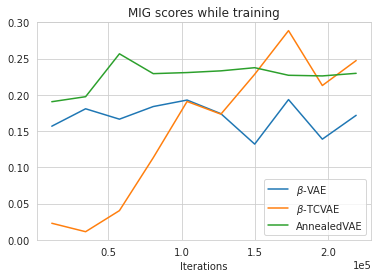

In [51]:
order = [f'model-{i}.pt' for i in range(1,20,2)]
itrs = [i*11520 for i in range(1,20,2)]
ax1 = plt.subplot(111)
for model in [constant,monotic,annealedVAE]:
    ax1.plot(itrs,[model[f]['discrete_mig'] for f in order])
plt.title('MIG scores while training')
ax1.xaxis.get_major_formatter().set_powerlimits((0,1))
ax1.set_xlabel('Iterations')
plt.ylim(0,0.3)
plt.legend([r'$\beta$-VAE',r'$\beta$-TCVAE','AnnealedVAE'])
plt.savefig('MIG_approaches.pdf')

## betaVAE

In [10]:
r = api.run('erow/fractionVAE/nmi90ru0')
his=r.history(keys=['KL_loss','recon_loss','loss'])
his # 每10个step记录一次

,_step,KL_loss,recon_loss,loss
0,98,8.081237,473.632222,522.119644
1,220,9.367277,277.949705,334.153365
2,290,9.688765,236.217086,294.349678
3,342,9.845095,215.653710,274.724278
4,412,9.994558,195.836516,255.803862
...,...,...,...,...
493,34285,12.570450,48.664552,124.087253
494,34355,12.571281,48.664242,124.091928
495,34425,12.571628,48.631415,124.061184
496,34477,12.571392,48.602769,124.031120


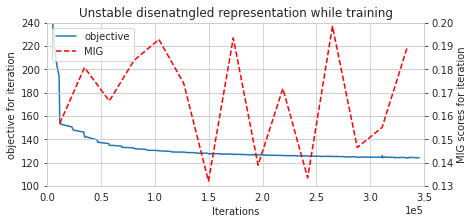

In [11]:
plt.figure(figsize=(6.75,3))
ax1 = plt.subplot(111)
plt.title('Unstable disenatngled representation while training')
lin1=plt.plot(his['_step']*10,his[['loss']],)
ax1.set_ylabel('objective for iteration')
ax1.set_ylim(100,240)
ax1.set_xlim(0,350000)
ax2 = ax1.twinx()
lin2=ax2.plot([i*11520 for i in range(1,30,2)],[constant[f]['discrete_mig'] for f in order],'r--',)
ax2.set_ylabel('MIG scores for iteration')
ax2.set_ylim(0.13,0.2)

ax1.xaxis.get_major_formatter().set_powerlimits((0,1))
ax1.set_xlabel('Iterations')
plt.legend(lin1+lin2,['objective','MIG'])
plt.savefig('pics/unstable.pdf')

In [61]:
keys=order #list(constant.keys())
w = len(keys)
models = constant

data = np.zeros((2,5,w))
for i in range(w):
    nMI = np.array(models[keys[i]]['discrete_mi'])/np.log([3,6,40,32,32])
    nMI.sort(0)
    print((nMI[-1]-nMI[-2]).mean())
    data[0,:,i]=nMI[-1]
    data[1,:,i]=nMI[-2]


0.15670299584215708
0.18073283250539401
0.16639148392307807
0.1837943906839012
0.192741195251263
0.17397376458610117
0.13198368747444086
0.19340667813039705
0.13879157093677963
0.171703597283284
0.13340161128275
0.19842405240666877
0.14638553558506134
0.15495396685366525
0.18888348747773884


<AxesSubplot:>

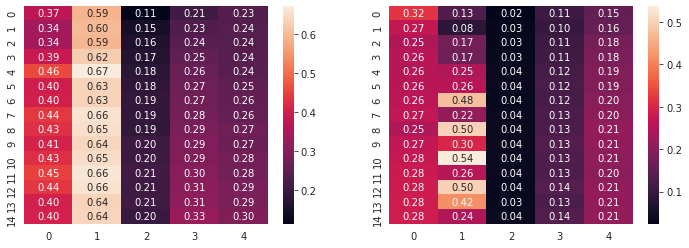

In [62]:
fig, axes = plt.subplots(1,2,figsize=(2*6,4))
sns.heatmap(data[0].transpose(),fmt='.2f',ax=axes[0],annot=True)
sns.heatmap(data[1].transpose(),fmt='.2f',ax=axes[1],annot=True)

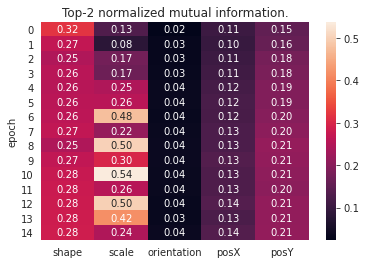

In [67]:
# plt.figure(figsize=(8,4))
sns.heatmap(data[1,:].transpose(),
            annot=True,fmt='.2f',xticklabels=['shape','scale','orientation','posX','posY'])
plt.title('Top-2 normalized mutual information.')
plt.ylabel('epoch')
plt.yticks(rotation = 0)
plt.savefig('visualization/constant_top2.pdf',bbox_inches='tight')

# 

# annealedVAE 的问题

In [15]:
order = [f'model-{i}.pt' for i in range(1,40,2)]
annealedVAE.keys()

dict_keys(['model-1.pt', 'model-11.pt', 'model-13.pt', 'model-15.pt', 'model-17.pt', 'model-19.pt', 'model-21.pt', 'model-23.pt', 'model-25.pt', 'model-27.pt', 'model-29.pt', 'model-3.pt', 'model-31.pt', 'model-33.pt', 'model-35.pt', 'model-37.pt', 'model-39.pt', 'model-5.pt', 'model-7.pt', 'model-9.pt'])

In [16]:
df=pd.DataFrame([ map(lambda x:x.item(),[annealedVAE[k]['mi'].mean(),annealedVAE[k]['tc'].mean(),annealedVAE[k]['dw'].mean()]) for k in order])
df.to_csv('annealedVAE_decomposition.csv',header=None)
df

,0,1,2
0,66.020401,-62.363964,0.154365
1,67.986313,-62.074978,1.332660
2,69.242233,-61.027084,1.897142
3,69.331299,-58.655025,2.337475
4,69.368889,-56.340874,2.892000
5,69.369263,-54.759048,4.204164
6,69.369263,-53.807812,6.135406
7,69.369263,-53.473351,8.632369
8,69.369263,-53.088394,11.136356
9,69.369263,-52.720596,13.676914


In [13]:
itrs=[11520+11520*2*i for i in range(20)]

In [35]:
itrs[-1]

449280

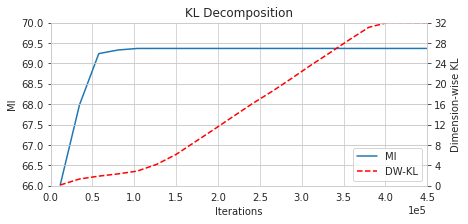

In [17]:
sns.set_style("whitegrid")
plt.figure(figsize=(6.75,3))
ax1 = plt.subplot(111)
plt.title('KL Decomposition')
lin1=plt.plot(itrs,df[0])
ax1.set_ylabel('MI')
ax1.set_ylim(66,70)
ax1.set_xlim(0,450000)
ax2 = ax1.twinx()
lin2=ax2.plot(itrs,df[2],'r--',)
ax2.set_ylabel('Dimension-wise KL')
ax2.set_ylim(0,32.0)
ax2.set_yticks(range(0,33,4))

ax1.xaxis.get_major_formatter().set_powerlimits((0,1))
ax1.set_xlabel('Iterations')
plt.legend(lin1+lin2,['MI','DW-KL'],loc=4)
plt.savefig('pics/annealed_decomposition.pdf',bbox_inches='tight')

In [19]:
%matplotlib inline

In [39]:
keys=order #list(constant.keys())
w = len(keys)
models = annealedVAE

data = np.zeros((2,5,w))
for i in range(w):
    nMI = np.array(models[keys[i]]['discrete_mi'])/np.log([3,6,40,32,32])
    nMI.sort(0)
    print((nMI[-1]-nMI[-2]).mean())
    data[0,:,i]=nMI[-1]
    data[1,:,i]=nMI[-2]

0.1904191720488099
0.19738775909948486
0.2565124560723079
0.22913859175643347
0.23065448583484366
0.23300035269932887
0.23735947320048636
0.22692504846429426
0.2260366641488479
0.22962381399991968
0.24387734730199084
0.22940369374075545
0.22454849723391335
0.26091743727473127
0.23260591965888242
0.25511483097182436
0.2600052791735993
0.22644525198719262
0.21485164230854353
0.25477305234559305


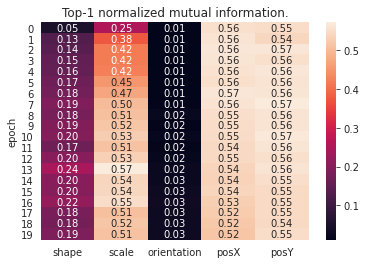

In [40]:
# fig, axes = plt.subplots(1,2,figsize=(2*8,4))
# plt.figure(figsize=(8,4))
sns.heatmap(data[0,:].transpose(),
            annot=True,fmt='.2f',xticklabels=['shape','scale','orientation','posX','posY'])
# plt.ylabel('epoch')
# sns.heatmap(data[1,3:],ax=axes[1],annot=True)
plt.title('Top-1 normalized mutual information.')
plt.ylabel('epoch')
plt.savefig('visualization/anneal_top1.pdf',bbox_inches='tight')

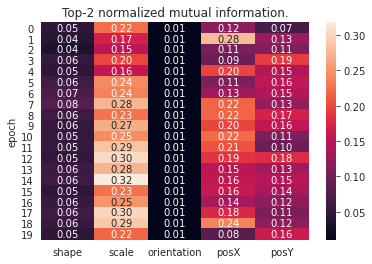

In [41]:
sns.heatmap(data[1,:].transpose(),
            annot=True,fmt='.2f',xticklabels=['shape','scale','orientation','posX','posY'])
# plt.ylabel('epoch')
# sns.heatmap(data[1,3:],ax=axes[1],annot=True)
plt.title('Top-2 normalized mutual information.')
plt.ylabel('epoch')
plt.savefig('visualization/anneal_top2.pdf',bbox_inches='tight')

In [61]:
import seaborn as sns

In [32]:
keys=order #list(constant.keys())
w = len(keys)
models = annealedVAE
fig, axes = plt.subplots(1,2,figsize=(2*6,4))
data = np.zeros((2,5,w))
for i in range(w):
    nMI = np.array(models[keys[i]]['discrete_mi'])/np.log([3,6,40,32,32])
    nMI.sort(0)
    print((nMI[-1]-nMI[-2]).mean())
    data[0,:,i]=nMI[-1]
    data[1,:,i]=nMI[-2]
sns.heatmap(data[0],ax=axes[0],annot=True)
sns.heatmap(data[1],ax=axes[1],annot=True)

NameError: name 'order' is not defined